In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [43]:
#Сбор датасета для проверки
data = []
for star in range(1, 11):
    titles = ['tt2820852', 'tt7286456', 'tt1950186']
    for title in titles:
        link = f'http://www.imdb.com/title/{title}/reviews?sort=helpfulnessScore&dir=desc&ratingFilter={star}'
        content = requests.get(link).text
        soup = BeautifulSoup(content, 'html')
        reviews = soup.find_all("div", {"class": "text show-more__control"})
        for review in reviews:
            data.append([star, review.text])

In [62]:
dataframe = pd.DataFrame(data, columns=['Target', 'Text'])
dataframe.to_csv('review_ratings.csv', index=False)
dataframe

,Target,Text
0,1,"Movie is so boring and very unrealistic, peopl..."
1,1,I never understood why this franchise always m...
2,1,the first one in the series was okay > Five wa...
3,1,If I am being punked - this is the best punk e...
4,1,An action movie can indeed have a great story ...
...,...,...
696,10,A friend asked me to go see it and I hadn't he...
697,10,I actually agree with some of the other commen...
698,10,Honestly cannot believe how good this film is!...
699,10,Ok perhaps not perfect. But so much more than ...


Checking performance of two models:
    1. Rescaling predictions
    2. Mapping predictions to rating

In [2]:
dataframe = pd.read_csv('review_ratings.csv')

In [3]:
import pickle

with open('./models/model_final.pkl', 'rb') as f:
    model = pickle.load(f)

with open('./models/vectorizer_final.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('./models/rating.pkl', 'rb') as f:
    rating_map = pickle.load(f)

In [4]:
features = vectorizer.transform(dataframe['Text'].values)
predictions = model.predict_proba(features)

In [8]:
from sklearn.metrics import mean_squared_error

mapped_predictions = rating_map(predictions.T[1])

print('MSE Without map: ', mean_squared_error(dataframe['Target'], predictions.T[1] * 9 + 1))
print('MSE With map: ', mean_squared_error(dataframe['Target'], mapped_predictions * 10))

MSE Without map:  5.442497692092493
MSE With map:  4.423994617281439


In [19]:
data = []
for class_value in range(1, 11):
    df = dataframe[dataframe['Target'] == class_value]
    indexes = df.index
    MSE_1 = mean_squared_error(df['Target'], predictions.T[1][indexes] * 9 + 1)
    MSE_2 = mean_squared_error(df['Target'], mapped_predictions[indexes] * 10)
    
    data.append([round(MSE_1, 3), round(MSE_2, 3)])
    
error = pd.DataFrame(data, index=[f'MSE_{i}' for i in range(1, 11)], columns=['Rescaling', 'Mapping']).T
error.to_csv('mse_info.csv', index=True)

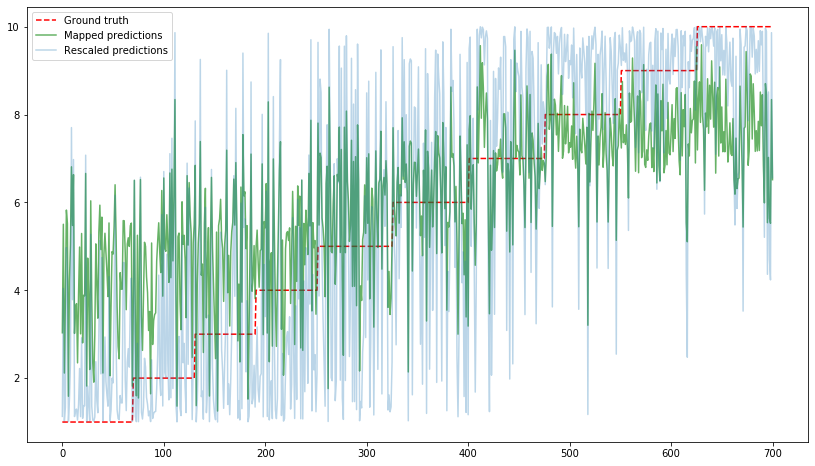

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(dataframe['Target'].values, linestyle='--', color='red', label='Ground truth')
plt.plot(mapped_predictions * 10, alpha=0.6, color='green', label='Mapped predictions')
plt.plot(predictions.T[1] * 9 + 1, alpha=0.3, label='Rescaled predictions')
plt.legend()